<a href="https://colab.research.google.com/github/ANASWARAASOKAN/LSTM-Bi-GRU/blob/master/LSTM_Bidirectional_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Amazon Reviews Text Summarization - Internship 2020***

---


## **LSTM Bidirectional GRU**

### Kaggle Dataset Extraction

In [ ]:
#installing kaggle to import the dataset....directly
!pip install kaggle


In [ ]:
#Importing Kaggle.json file...
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"hritikgupta121","key":"1d4fa0226f212bc40fa54abf300c68d6"}'}

In [ ]:
!mkdir -p ~/.kaggle

!cp kaggle.json ~/.kaggle/


In [ ]:
#changing the permission to kaggle file
!chmod 600 ~/.kaggle/kaggle.json

### Downloading the dataset from Kaggle Site

In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

amazonreviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip amazonreviews.zip 

Archive:  amazonreviews.zip
replace test.ft.txt.bz2? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


Importing the modules

In [ ]:
import bz2
import os
import pandas as pd
import string
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
os.listdir('/content/')

['.config',
 'kaggle (2).json',
 'kaggle.json',
 'test.ft.txt.bz2',
 'train.ft.txt.bz2',
 'amazonreviews.zip',
 'kaggle (1).json',
 'sample_data']

### Reading the Dataset 

In [ ]:
trainfile = bz2.BZ2File('/content/train.ft.txt.bz2','r')
testfile = bz2.BZ2File('/content/test.ft.txt.bz2','r')
lines = trainfile.readlines()
lines[0]

b'__label__2 Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^\n'

In [ ]:
len(lines)

3600000

In [ ]:
docSentimentList=[]
def getDocumentSentimentList(docs,splitStr='__label__'):
    for i in range(len(docs)):
        #print('Processing doc ',i,' of ',len(docs))
        text=str(lines[i])
        #print(text)
        splitText=text.split(splitStr)
        secHalf=splitText[1]
        text=secHalf[2:len(secHalf)-1]
        sentiment=secHalf[0]
        #print('First half:',secHalf[0],'\nsecond half:',secHalf[2:len(secHalf)-1])
        docSentimentList.append([text,sentiment])
    print('Done!!')
    return docSentimentList

In [ ]:
docSentimentList=getDocumentSentimentList(lines[:1000000],splitStr='__label__')

Done!!


In [ ]:
train_df = pd.DataFrame(docSentimentList,columns=['Text','Sentiment'])
train_df.head()

,Text,Sentiment
0,Stuning even for the non-gamer: This sound tra...,2
1,The best soundtrack ever to anything.: I'm rea...,2
2,Amazing!: This soundtrack is my favorite music...,2
3,Excellent Soundtrack: I truly like this soundt...,2
4,"Remember, Pull Your Jaw Off The Floor After He...",2


### Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [ ]:
train_df.describe()

,Text,Sentiment
count,1000000,1000000
unique,1000000,2
top,She tells it like it is...: See the starts of ...,2
freq,1,505678


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [ ]:
train_df.groupby('Sentiment').describe()

Text  ...     
            count  ... freq
Sentiment          ...     
1          494322  ...    1
2          505678  ...    1

[2 rows x 4 columns]

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [ ]:
train_df['length'] = train_df['Text'].apply(len)
train_df.head()
train_df.iloc[:1]

,Text,Sentiment,length
0,Stuning even for the non-gamer: This sound tra...,2,428


### Data Visualization
Let's visualize this! Let's do the imports:

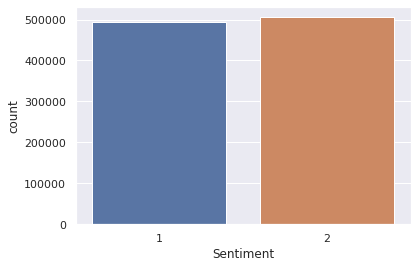

In [ ]:
import seaborn as sns
sns.set(style="darkgrid")
sns.countplot(x="Sentiment", data=train_df)

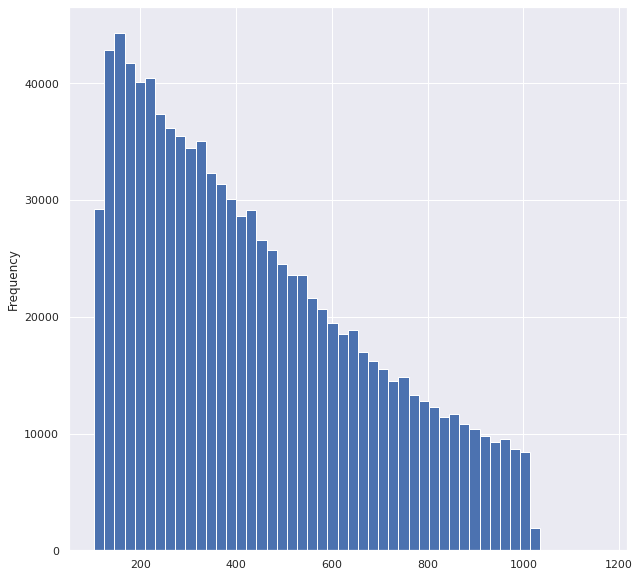

In [ ]:
import seaborn as sns
train_df['length'].plot(bins=50, kind='hist',figsize = (10,10)) 

In [ ]:
train_df.length.describe()

count    1000000.000000
mean         439.482006
std          239.716708
min          103.000000
25%          237.000000
50%          392.000000
75%          607.000000
max         1163.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f28e6c86f98>,
      dtype=object)

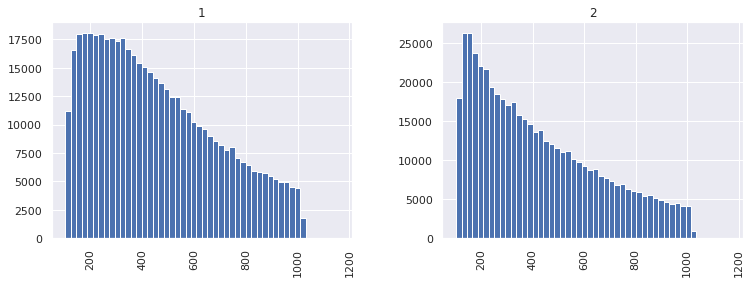

In [ ]:
train_df.hist(column='length', by='Sentiment', bins=50,figsize=(12,4))

### Data PreProcessing

In [ ]:
train_df['Sentiment'][train_df['Sentiment']=='1'] = 0
train_df['Sentiment'][train_df['Sentiment']=='2'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
train_df['Sentiment'].value_counts()

1    505678
0    494322
Name: Sentiment, dtype: int64

In [ ]:
train_df['word_count'] = train_df['Text'].str.lower().str.split().apply(len)
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the non-gamer: This sound tra...,1,428,80
1,The best soundtrack ever to anything.: I'm rea...,1,511,97
2,Amazing!: This soundtrack is my favorite music...,1,768,129
3,Excellent Soundtrack: I truly like this soundt...,1,745,118
4,"Remember, Pull Your Jaw Off The Floor After He...",1,483,87


In [ ]:
import string 
def remove_punc(s):
    table = str.maketrans({key: None for key in string.punctuation})
    return s.translate(table)

In [ ]:
train_df['Text'] = train_df['Text'].apply(remove_punc)
train_df.shape

(1000000, 4)

In [ ]:
train_df.head()

,Text,Sentiment,length,word_count
0,Stuning even for the nongamer This sound track...,1,428,80
1,The best soundtrack ever to anything Im readin...,1,511,97
2,Amazing This soundtrack is my favorite music o...,1,768,129
3,Excellent Soundtrack I truly like this soundtr...,1,745,118
4,Remember Pull Your Jaw Off The Floor After Hea...,1,483,87


In [ ]:
len(train_df['word_count'][train_df['word_count']<=25])

63720

In [ ]:
train_df1 = train_df[:][train_df['word_count']<=25]
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [ ]:
train_df1.head()

,Text,Sentiment,length,word_count
44,autumn got this for my daughter in NC she is n...,1,112,22
58,Hunting the Hard Way Thia was a gift for my Hu...,1,121,25
77,Smells divine This is my second bottle of shee...,1,145,25
78,Very disappointed This perfume is just AWFUL S...,0,155,24
99,Caution These tracks are not the original vers...,0,148,22


In [ ]:
train_df1['Sentiment'].value_counts()

1    39932
0    23788
Name: Sentiment, dtype: int64

In [ ]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
st_wd = text.ENGLISH_STOP_WORDS
c_vector = CountVectorizer(stop_words = st_wd,min_df=.0001,lowercase=1)
c_vector.fit(train_df1['Text'].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=1, max_df=1.0, max_features=None, min_df=0.0001,
                ngram_range=(1, 1), preprocessor=None,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}),
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
word_list = list(c_vector.vocabulary_.keys())
stop_words = list(c_vector.stop_words) 

In [ ]:
len(stop_words),len(word_list)

(318, 8915)

In [ ]:
def remove_words(raw_sen,stop_words):
    sen = [w for w in raw_sen if w not in stop_words]
    return sen

In [ ]:
def reviewEdit(raw_sen_list,stop_words):
    sen_list = []
    for i in range(len(raw_sen_list)):
        raw_sen = raw_sen_list[i].split()
        sen_list.append(remove_words(raw_sen,stop_words))
    return sen_list

In [ ]:
sen_list = reviewEdit(list(train_df1['Text']),stop_words)

### Word2Vec Creation

In [ ]:
from gensim.models import word2vec
wv_model = word2vec.Word2Vec(sen_list,size=100)

In [ ]:
wv_model.wv.syn0.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


(14350, 100)

In [ ]:
wv_model.wv.most_similar("car")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pair', 0.919621467590332),
 ('bottle', 0.9140369892120361),
 ('computer', 0.9109147787094116),
 ('hair', 0.9067609906196594),
 ('lights', 0.9051272869110107),
 ('headphones', 0.903363823890686),
 ('cameras', 0.8942911624908447),
 ('cards', 0.89035964012146),
 ('pants', 0.8898195028305054),
 ('head', 0.8897041082382202)]

In [ ]:
import numpy as np
def fun(sen_list,wv_model):
    word_set = set(wv_model.wv.index2word)
    X = np.zeros([len(sen_list),25,100])
    c = 0
    for sen in sen_list:
        nw=24
        for w in list(reversed(sen)):
            if w in word_set:
                X[c,nw] = wv_model[w]
                nw=nw-1
        c=c+1
    return X

In [ ]:
X = fun(sen_list,wv_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
from sklearn.model_selection import train_test_split
y = train_df1['Sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train.shape

(57348, 25, 100)

### Model Building - Bidirectional LSTM GRU

In [ ]:
import keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Activation,LSTM, SimpleRNN ,GRU , Bidirectional,Input ,Concatenate, Multiply,Lambda,Reshape
input_st  = Input(shape=(25,100))
lstm1 = Bidirectional(GRU(200,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(input_st)
lstm2 = Bidirectional(GRU(1,input_shape=(25,100),activation='relu',return_sequences=True),merge_mode='mul')(lstm1)
print(lstm1.shape,' ',lstm2.shape)
lstm2 = Reshape((-1,))(lstm2)
lstm2 = Activation('sigmoid')(lstm2)
lstm2 = Reshape((-1,1))(lstm2)
mult = Multiply()([lstm1,lstm2])

add = Lambda(lambda x: K.sum(x,axis=1))(mult)
dense = Dense(100,activation='relu')(add)
output = Dense(1,activation='sigmoid')(dense)

model = Model(inputs=input_st, outputs=output)
print(model.summary())

(None, 25, 200)   (None, 25, 1)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 25, 100)      0                                            
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 25, 200)      361200      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_6 (Bidirectional) (None, 25, 1)        1212        bidirectional_5[0][0]            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 25)           0           bidirectional_6[0][0]            
____________________________________________________________

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
hist = model.fit(X_train,y_train,validation_split=0.1,epochs=10, batch_size=512,callbacks=[early_stop])

Train on 51613 samples, validate on 5735 samples
Epoch 1/10
51613/51613 [==============================] - 118s 2ms/step - loss: 0.3451 - accuracy: 0.8476 - val_loss: 0.3125 - val_accuracy: 0.8673
Epoch 2/10
51613/51613 [==============================] - 119s 2ms/step - loss: 0.2846 - accuracy: 0.8810 - val_loss: 0.2820 - val_accuracy: 0.8842
Epoch 3/10
51613/51613 [==============================] - 124s 2ms/step - loss: 0.2638 - accuracy: 0.8901 - val_loss: 0.2710 - val_accuracy: 0.8893
Epoch 4/10
51613/51613 [==============================] - 124s 2ms/step - loss: 0.2489 - accuracy: 0.8956 - val_loss: 0.2798 - val_accuracy: 0.8821
Epoch 5/10
51613/51613 [==============================] - 119s 2ms/step - loss: 0.2396 - accuracy: 0.9000 - val_loss: 0.2548 - val_accuracy: 0.8929
Epoch 6/10
51613/51613 [==============================] - 120s 2ms/step - loss: 0.2291 - accuracy: 0.9038 - val_loss: 0.2568 - val_accuracy: 0.8952
Epoch 7/10
51613/51613 [==============================] - 116s 

### Model Evaluation

In [ ]:
model.evaluate(X_test, y_test, batch_size=64)

6372/6372 [==============================] - 6s 866us/step


[0.25106015681696625, 0.894695520401001]

In [ ]:
scores = model.evaluate(X_test, y_test)
print("Test acc: %.2f%%" % (scores[1]*100))

6372/6372 [==============================] - 6s 866us/step
Test acc: 89.47%


In [ ]:
model.evaluate(X_train, y_train, batch_size=1024)

57348/57348 [==============================] - 29s 508us/step


[0.2213911877280791, 0.9064134955406189]

In [ ]:
scores = model.evaluate(X_train, y_train)
print("Train acc: %.2f%%" % (scores[1]*100))

57348/57348 [==============================] - 50s 871us/step
Train acc: 90.64%


### Classification Matrix

In [ ]:
prob_test = model.predict(X_test).reshape((-1,))
pred_test = np.array([1 if y>0.5 else 0 for y in prob_test])
y_test = y_test.astype('int')
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      2367
           1       0.89      0.95      0.92      4005

    accuracy                           0.89      6372
   macro avg       0.90      0.88      0.88      6372
weighted avg       0.90      0.89      0.89      6372



### Confusion Matrix

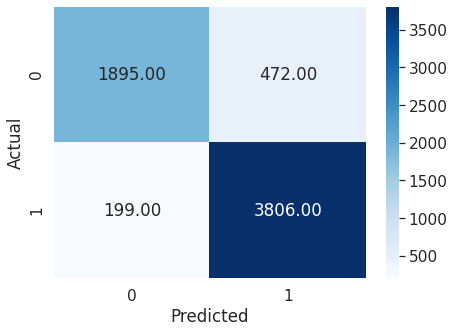

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
data = confusion_matrix(y_test, pred_test)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, fmt='.2f')

### ROC-AUC and other curves

No handles with labels found to put in legend.


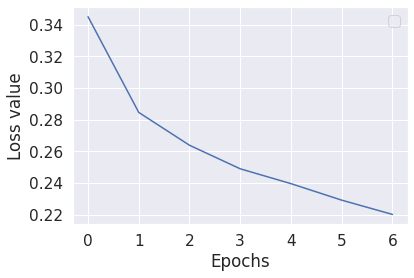

In [ ]:
import matplotlib.pyplot as plt
loss_curve = hist.history['loss']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.plot(epoch_c,loss_curve)
plt.legend()
plt.show()

No handles with labels found to put in legend.


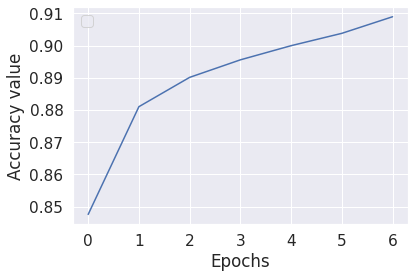

In [ ]:
accuracy_curve = hist.history['accuracy']
epoch_c = list(range(len(loss_curve)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy value')
plt.plot(epoch_c,accuracy_curve)
plt.legend()
plt.show()

In [ ]:


from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)



In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

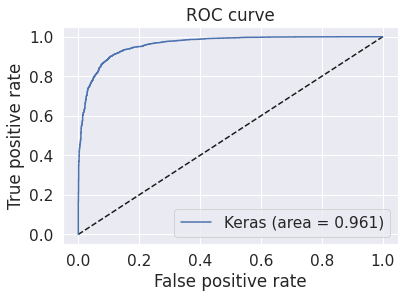

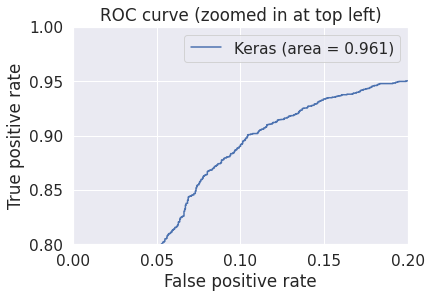

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()